In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [236]:
# df = pd.read_csv('sp500.csv')
# https://fred.stlouisfed.org/series/SP500
df = pd.read_csv('sp500_19_20.csv', ); 
df.columns = ['Date', 'Close']; df = df[df.Close != '.']; df['Close'] = df['Close'].astype(float)

In [263]:
def get_invest(data, is_verbal=False):
    n_stock = 0.0
    Money = 100.0
    sign = 0
    for i in data.iterrows():
        sign = i[1]['sign_change']
        if i[0] == 0 or (sign == 1 and Money > 0):
            n_stock = Money / i[1]['Close']
            if is_verbal:
                print(f'''On {i[1]['Date']}, close price is {i[1]['Close']}, spend {Money:.1f} money to get {n_stock:.4f} stocks''')
            Money = 0.0
        if sign == -1 and n_stock > 0:
            Money = n_stock * i[1]['Close']
            n_stock = 0.0
            if is_verbal:
                print(f'''On {i[1]['Date']}, close price is {i[1]['Close']}, sell all stocks to get {Money:.1f} cash''')
    if is_verbal:
        print(f'''On {i[1]['Date']}, have {Money:.1f}, and {i[1]['Close'] * n_stock:.1f} worth of stock''')
    return Money + i[1]['Close'] * n_stock

In [238]:
# t1 = 10; t2 = 20

results_train = []
for t1 in range(5, 50, 5):
    for t2 in range(10, 100, 10):
        if t2 <= t1:
            continue
        # df['ma_t1'] = df.Close.rolling(t1).mean()
        # df['ma_t2'] = df.Close.rolling(t2).mean()
        df['ma_t1'] = df.Close.ewm(span=t1).mean()
        df['ma_t2'] = df.Close.ewm(span=t2).mean()

        df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
        df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
        df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

        dfp = df[(df.Date > '2018-12-31') & (df.Date <= '2019-12-31')].copy().reset_index(drop=True)

        results_train.append((get_invest(dfp), t1, t2))

In [239]:
results_test = []
for money_train, t1, t2 in sorted(results_train, reverse=True)[:20]:
    if t2 <= t1:
        continue
    # df['ma_t1'] = df.Close.rolling(t1).mean()
    # df['ma_t2'] = df.Close.rolling(t2).mean()
    df['ma_t1'] = df.Close.ewm(span=t1).mean()
    df['ma_t2'] = df.Close.ewm(span=t2).mean()

    df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
    df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
    df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

    dfp = df[df.Date > '2019-12-31'].copy().reset_index(drop=True)
    results_test.append((get_invest(dfp), t1, t2))

In [264]:
# sorted(results_test, reverse=True)[:20]

# sorted(results_train, reverse=True)[:20]

5 20
On 2019-01-02, close price is 2510.03, spend 100.0 money to get 0.0398 stocks
On 2019-05-08, close price is 2879.42, sell all stocks to get 114.7 cash
On 2019-06-07, close price is 2873.34, spend 114.7 money to get 0.0399 stocks
On 2019-08-01, close price is 2953.56, sell all stocks to get 117.9 cash
On 2019-09-04, close price is 2937.78, spend 117.9 money to get 0.0401 stocks
On 2019-10-01, close price is 2940.25, sell all stocks to get 118.0 cash
On 2019-10-15, close price is 2995.68, spend 118.0 money to get 0.0394 stocks
On 2020-01-31, close price is 3225.52, sell all stocks to get 127.1 cash
On 2020-02-04, close price is 3297.59, spend 127.1 money to get 0.0385 stocks
On 2020-02-24, close price is 3225.89, sell all stocks to get 124.3 cash
On 2020-04-08, close price is 2749.98, spend 124.3 money to get 0.0452 stocks
On 2020-06-26, close price is 3009.05, sell all stocks to get 136.0 cash
On 2020-07-01, close price is 3115.86, spend 136.0 money to get 0.0437 stocks
On 2020-09-

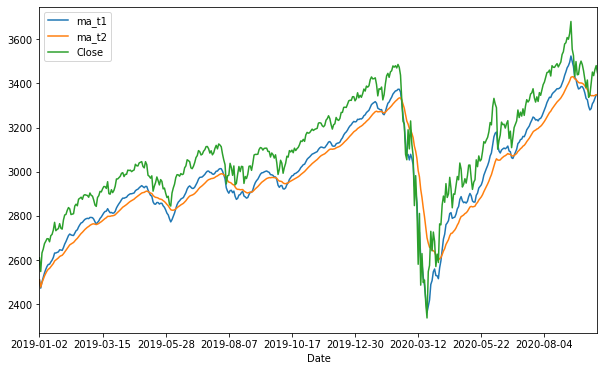

In [266]:
for money_train, t1, t2 in sorted(results_test, reverse=True)[:1]:
    if t2 <= t1:
        continue
    print(t1, t2)
    # df['ma_t1'] = df.Close.rolling(t1).mean()
    # df['ma_t2'] = df.Close.rolling(t2).mean()
    df['ma_t1'] = df.Close.ewm(span=t1).mean()
    df['ma_t2'] = df.Close.ewm(span=t2).mean()

    df['d_t1_t2'] = df['ma_t1'] - df['ma_t2']
    df['d_t1_t2_sign'] = df['d_t1_t2'] > 0
    df['sign_change'] = (df['d_t1_t2_sign'] - df['d_t1_t2_sign'].shift())

    dfp = df.copy().reset_index(drop=True)
    print((get_invest(dfp, is_verbal=True), t1, t2))
        
f, a = plt.subplots(figsize=(10, 6))
dfp.Close = dfp.Close + 100
dfp = dfp.set_index('Date')
dfp[['ma_t1', 'ma_t2', 'Close']].plot(ax=a                        )

In [267]:
(dfp.Close.tail(1).values / dfp.Close.head(1).values * 100)[0]

132.12261928023815